# Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [36]:
from dotenv import load_dotenv
load_dotenv()
import os

# Set API Keys from environment variables
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_core.messages import AIMessage, HumanMessage, AnyMessage
from langchain_groq import ChatGroq
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

In [37]:
# define tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

tools = [add]

In [38]:
# define state
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [39]:
# llm + tool binding
llm = ChatGroq(model="qwen-qwq-32b")
llm_with_tools = llm.bind_tools(tools)

In [40]:
# Node: LLM Tool node

def llm_tool(state: State):
    # Given the state, invoke the LLM (with tool support) on the message history
    result = llm_with_tools.invoke(state["messages"])
    # Add the new LLM message to the state
    return {"messages": add_messages(state["messages"], result)}

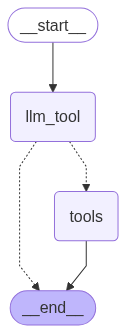

In [ ]:
# build the chain graph
# You can use prebuilt helpers for tools logic (optional, but clean)
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)

# Add nodes
builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    tools_condition  # routes to either tools node (if tool_call), else END
)
builder.add_edge("tools", END)

# Compile graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
# ask mathematics question - tool will be called

initial_messages = [
    HumanMessage(content="What is 2 plus 2", name="Vivek")
]

state = {"messages": initial_messages}
result = graph.invoke(state)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================
Name: Vivek

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (6gtezz34m)
 Call ID: 6gtezz34m
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [43]:
# normal question - no tool involved
initial_messages = [
    HumanMessage(content="What is Machine Learning?", name="Vivek")
]

state = {"messages": initial_messages}
result = graph.invoke(state)
for message in result["messages"]:
    message.pretty_print()


================================ Human Message =================================
Name: Vivek

What is Machine Learning?
================================== Ai Message ==================================

Machine Learning is a subset of artificial intelligence (AI) that focuses on developing algorithms and statistical models. These algorithms enable computers to improve their performance on a specific task over time by learning patterns from data, rather than relying solely on explicit instructions. Essentially, it allows systems to automatically improve through experience. Common applications include image recognition, spam detection, and recommendation systems.


#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.